In [1]:
import seaborn as sns # for correlation heatmap
import numpy as np
import pandas as pd
import tensorflow as tf
import xgboost as xgb
import pushranker
import datetime
import snrf
import importlib
import random
import pickle
import collections
import concurrent.futures
from matplotlib import pyplot as plt
from copy import deepcopy
from pathlib import Path
from xgboost import XGBClassifier, XGBRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from typing import List, Dict, Tuple, DefaultDict


In [29]:
push_type = 'scheduled' # local, targeted, scheduled
train_days = 2
train_day = '0622'
test_day = '0623'

LOCAL_DATA_ROOT = Path('./data/')
TRAIN_DATA_ROOT = str(LOCAL_DATA_ROOT / 'train' / 'edition=en_US' / f'push_type={push_type}' / train_day ) # / 'dt=2021-04-30-00')
TEST_DATA_ROOT = str(LOCAL_DATA_ROOT / 'test' / 'edition=en_US' / f'push_type={push_type}' / test_day) # / 'dt=2021-05-01-00')

training_format = snrf.package.get_obj_from_name(pushranker, 'survival_feature_spec.binarized_format_devicetoken')

# input_module = pushranker.local_push
input_module = importlib.import_module(f'pushranker.{push_type}_push')

print(TRAIN_DATA_ROOT)
print(TEST_DATA_ROOT)

data/train/edition=en_US/push_type=scheduled/0516
data/test/edition=en_US/push_type=scheduled/0517


In [30]:
def prepare(root, shuffle=None):
    ds = snrf.tfrecord.read_dataset_from_files(root)
#     ds = ds.shuffle(10000)
    ds = snrf.tfrecord.prepare_dataset_for_use(ds,
                                               input_module.input_spec,
                                               shuffle=shuffle,
                                               training_format=training_format)
    return ds

train_ds = prepare(TRAIN_DATA_ROOT, 10000)
test_ds = prepare(TRAIN_DATA_ROOT)
type(test_ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

## GBDT push ranker

In [4]:
# Transform push-ranker data for GBDT
numeric_features = ['predicted_ctr']
dense_features = ['cgScores', 'a_stats', 'af_dense', 'uf_dense', 'u_hhs']
dense_features_len = [10, 36, 9, 10, 24]
# sparse_features = [
#     'push_id', 'u_cate','u_catev2', 'u_hist_ids', 'u_pub', 'u_pub_ctr', 'u_kw',
#     'a_catev2', 'a_features', 'a_site_id', 'a_kw', 'a_tw'
# ]

def build_numeric_feature(batch) -> List[float]:
    samples = list()
    i = 0
    while True:
        value = list()
        try:
            for f in numeric_features:
                value.append(batch[0][f][i])
        except IndexError:
            break
        else:
            samples.append(value)
            i += 1
    return samples
    

def build_dense_feature(batch) -> List[List[float]]:
    samples = list()
    i = 0
    while True:
        feat_vec = list()
        try:
            for f in dense_features:
                feat_vec.extend(list(batch[0][f][i]))
        except IndexError:
            break
        else:
            samples.append(feat_vec)
            i += 1
    return samples
    

def build_sparse_feature_dict(batch) -> List[Dict]:
    samples = list()
    i = 0
    while True:
        featureDict = dict()
        try:
            for f in sparse_features:
                if f == 'push_id':
                    featureDict[f] = str(batch[0][f][i])  
                else:
                    featureDict[f] = [str(val) for idx, val in np.ndenumerate(batch[0][f][i]) if val]       
        except IndexError:
            break
        else:
            samples.append(featureDict)
            i += 1
    return samples

In [5]:
# # prepare training data
# numeric_feat = list()
# dense_feat = list()
# sparse_samples = list()

# for batch in train_ds.as_numpy_iterator():
#     numeric_feat.extend(build_numeric_feature(batch))
#     dense_feat.extend(build_dense_feature(batch))
# #     sparse_samples.extend(build_sparse_feature_dict(batch))
    
# numeric_feature = np.array(numeric_feat)
# numeric_feat.clear()
# dense_feature = np.array(dense_feat)
# dense_feat.clear()
dense_feature_column = [f'{df}_{i}' for df, l in zip(dense_features, dense_features_len) for i in range(l)]

# build sparse features transformer
# vec = DictVectorizer()
# sparse_feature = vec.fit_transform(sparse_samples).toarray()
# sparse_samples.clear()
# sparse_feature_column = vec.feature_names_
# sparse_feature.shape

In [6]:
# # merge training data
feature_columns = numeric_features + dense_feature_column# + sparse_feature_column
# train_X = np.hstack((numeric_feature, dense_feature))#, sparse_feature))
# train_X.shape

In [7]:
# # prepare testing data
# numeric_feat = list()
# dense_feat = list()
# sparse_samples = list()
# for batch in test_ds.as_numpy_iterator():
#     numeric_feat.extend(build_numeric_feature(batch))
#     dense_feat.extend(build_dense_feature(batch))
# #     sparse_samples.extend(build_sparse_feature_dict(batch))
# numeric_feature = np.array(numeric_feat)
# numeric_feat.clear()
# dense_feature = np.array(dense_feat)
# dense_feat.clear()
# # sparse_feature = vec.transform(sparse_samples).toarray()
# # sparse_samples.clear()
# test_X = np.hstack((numeric_feature, dense_feature))#, sparse_feature))
# numeric_feature.clear()
# dense_feature.clear()
# # sparse_feature.clear()
# test_X.shape

In [8]:
# # prepare labels
# train_y = list()
# test_y = list()

# for train in train_ds:
#     train_y.extend(list(np.array(train[1])))
    
# train_y = np.array(train_y)
# print(len(train_y))

# for test in test_ds:
#     test_y.extend(list(np.array(test[1])))
# test_y = np.array(test_y)
# print(len(test_y))


## XGBOOST API

In [9]:
# gbdt_model = None
# params = {'objective': 'binary:logistic'}
# for d in range(train_days):
#     day = day[:2] + str(int(day[2:]) - d)
#     train_X = np.load(str(LOCAL_DATA_ROOT / 'gbdt' / f'{push_type}-trainX-{day}.npy'))
#     train_y = np.load(str(LOCAL_DATA_ROOT / 'gbdt' / f'{push_type}-trainy-{day}.npy'))
#     xgb_train = xgb.DMatrix(train_X, label=train_y, feature_names=feature_columns)
#     print(f'Data of training day: {day}')
#     print(train_X.shape)
#     gbdt_model = xgb.train(params, xgb_train, xgb_model=gbdt_model)


In [10]:
# test_X = np.load(str(LOCAL_DATA_ROOT / 'gbdt' / f'{push_type}-testX-0501.npy'))
# test_y = np.load(str(LOCAL_DATA_ROOT / 'gbdt' / f'{push_type}-testy-0501.npy'))
# print(test_X.shape)
# test = xgb.DMatrix(test_X, label=test_y, feature_names=feature_columns)
# gbdt_pred_ctr = gbdt_model.predict(test)

In [11]:
# len(gbdt_pred_ctr)

In [12]:
# MODEL_ROOT_PATH = Path('./model')
# file_name = f"xgbmodel-{push_type}-{train_days}.xgbmodel"
# model_path = str(MODEL_ROOT_PATH / f'{push_type}-push' / 'GBDT' / file_name)
# gbdt_model.save_model(model_path)

In [13]:
# # feature_important = gbdt_model.get_booster().get_score(importance_type='weight')
# feature_important = gbdt_model.get_fscore()
# keys = list(feature_important.keys())
# values = list(feature_important.values())

# data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score")
# data.plot(kind='barh',figsize=(8,24))

## XGBOOST Sklearn API
Before starting the training job, run `prepare-gbdt-training-data` first to generate the training and testing data.

In [14]:
# %%time

# gbdt_model = xgb.XGBClassifier()
# # gbdt_model = xgb.XGBRegressor()

# # model = xgb.XGBRegressor(n_jobs=1)
# # clf = GridSearchCV(model,
# #                    {'max_depth': [2, 4, 6],
# #                     'n_estimators': [50, 100, 200]}, verbose=1, n_jobs=1)
# # clf.fit(train_X, train_y)
# # print(clf.best_score_)
# # print(clf.best_params_)
# tmp_model = None
# for d in range(train_days):
#     td = train_day[:2] + str(int(train_day[2:]) - d)
#     print(td)
#     train_X = np.load(str(LOCAL_DATA_ROOT / 'gbdt' / f'{push_type}-trainX-{td}.npy'))
#     train_y = np.load(str(LOCAL_DATA_ROOT / 'gbdt' / f'{push_type}-trainy-{td}.npy'))
#     tmp_model = gbdt_model.fit(train_X, train_y, xgb_model=tmp_model)


In [15]:
# model path
MODEL_ROOT_PATH = Path('./model')
file_name = f"xgbmodel-{push_type}-{train_day}-{train_days}.pkl"
model_path = str(MODEL_ROOT_PATH / f'{push_type}-push' / 'GBDT' / file_name)

# save
# pickle.dump(gbdt_model, open(model_path, "wb"))

# load
gbdt_model = pickle.load(open(model_path, "rb"))

In [16]:
train_X = np.load(str(LOCAL_DATA_ROOT / 'gbdt' / f'{push_type}-trainX-{train_day}.npy'))
train_y = np.load(str(LOCAL_DATA_ROOT / 'gbdt' / f'{push_type}-trainy-{train_day}.npy'))

In [17]:
test_X = np.load(str(LOCAL_DATA_ROOT / 'gbdt' / f'{push_type}-testX-{test_day}.npy'))
test_y = np.load(str(LOCAL_DATA_ROOT / 'gbdt' / f'{push_type}-testy-{test_day}.npy'))
print(test_X.shape)

(36052789, 90)


In [18]:
print(sum(train_y))
print(sum(test_y))

2149168
2501688


In [19]:
# plot_confusion_matrix(gbdt_model, test_X, test_y)
# plt.show()

In [20]:
%%time
gbdt_pred = gbdt_model.predict_proba(test_X)
# gbdt_pred = gbdt_model.predict(test_X) # for regressor
len(gbdt_pred)

CPU times: user 2min 34s, sys: 253 ms, total: 2min 34s
Wall time: 5.23 s


36052789

In [21]:
gbdt_pred_ctr = gbdt_pred[:, 1]
# gbdt_pred_ctr = gbdt_pred # for regressor

<BarContainer object of 90 artists>

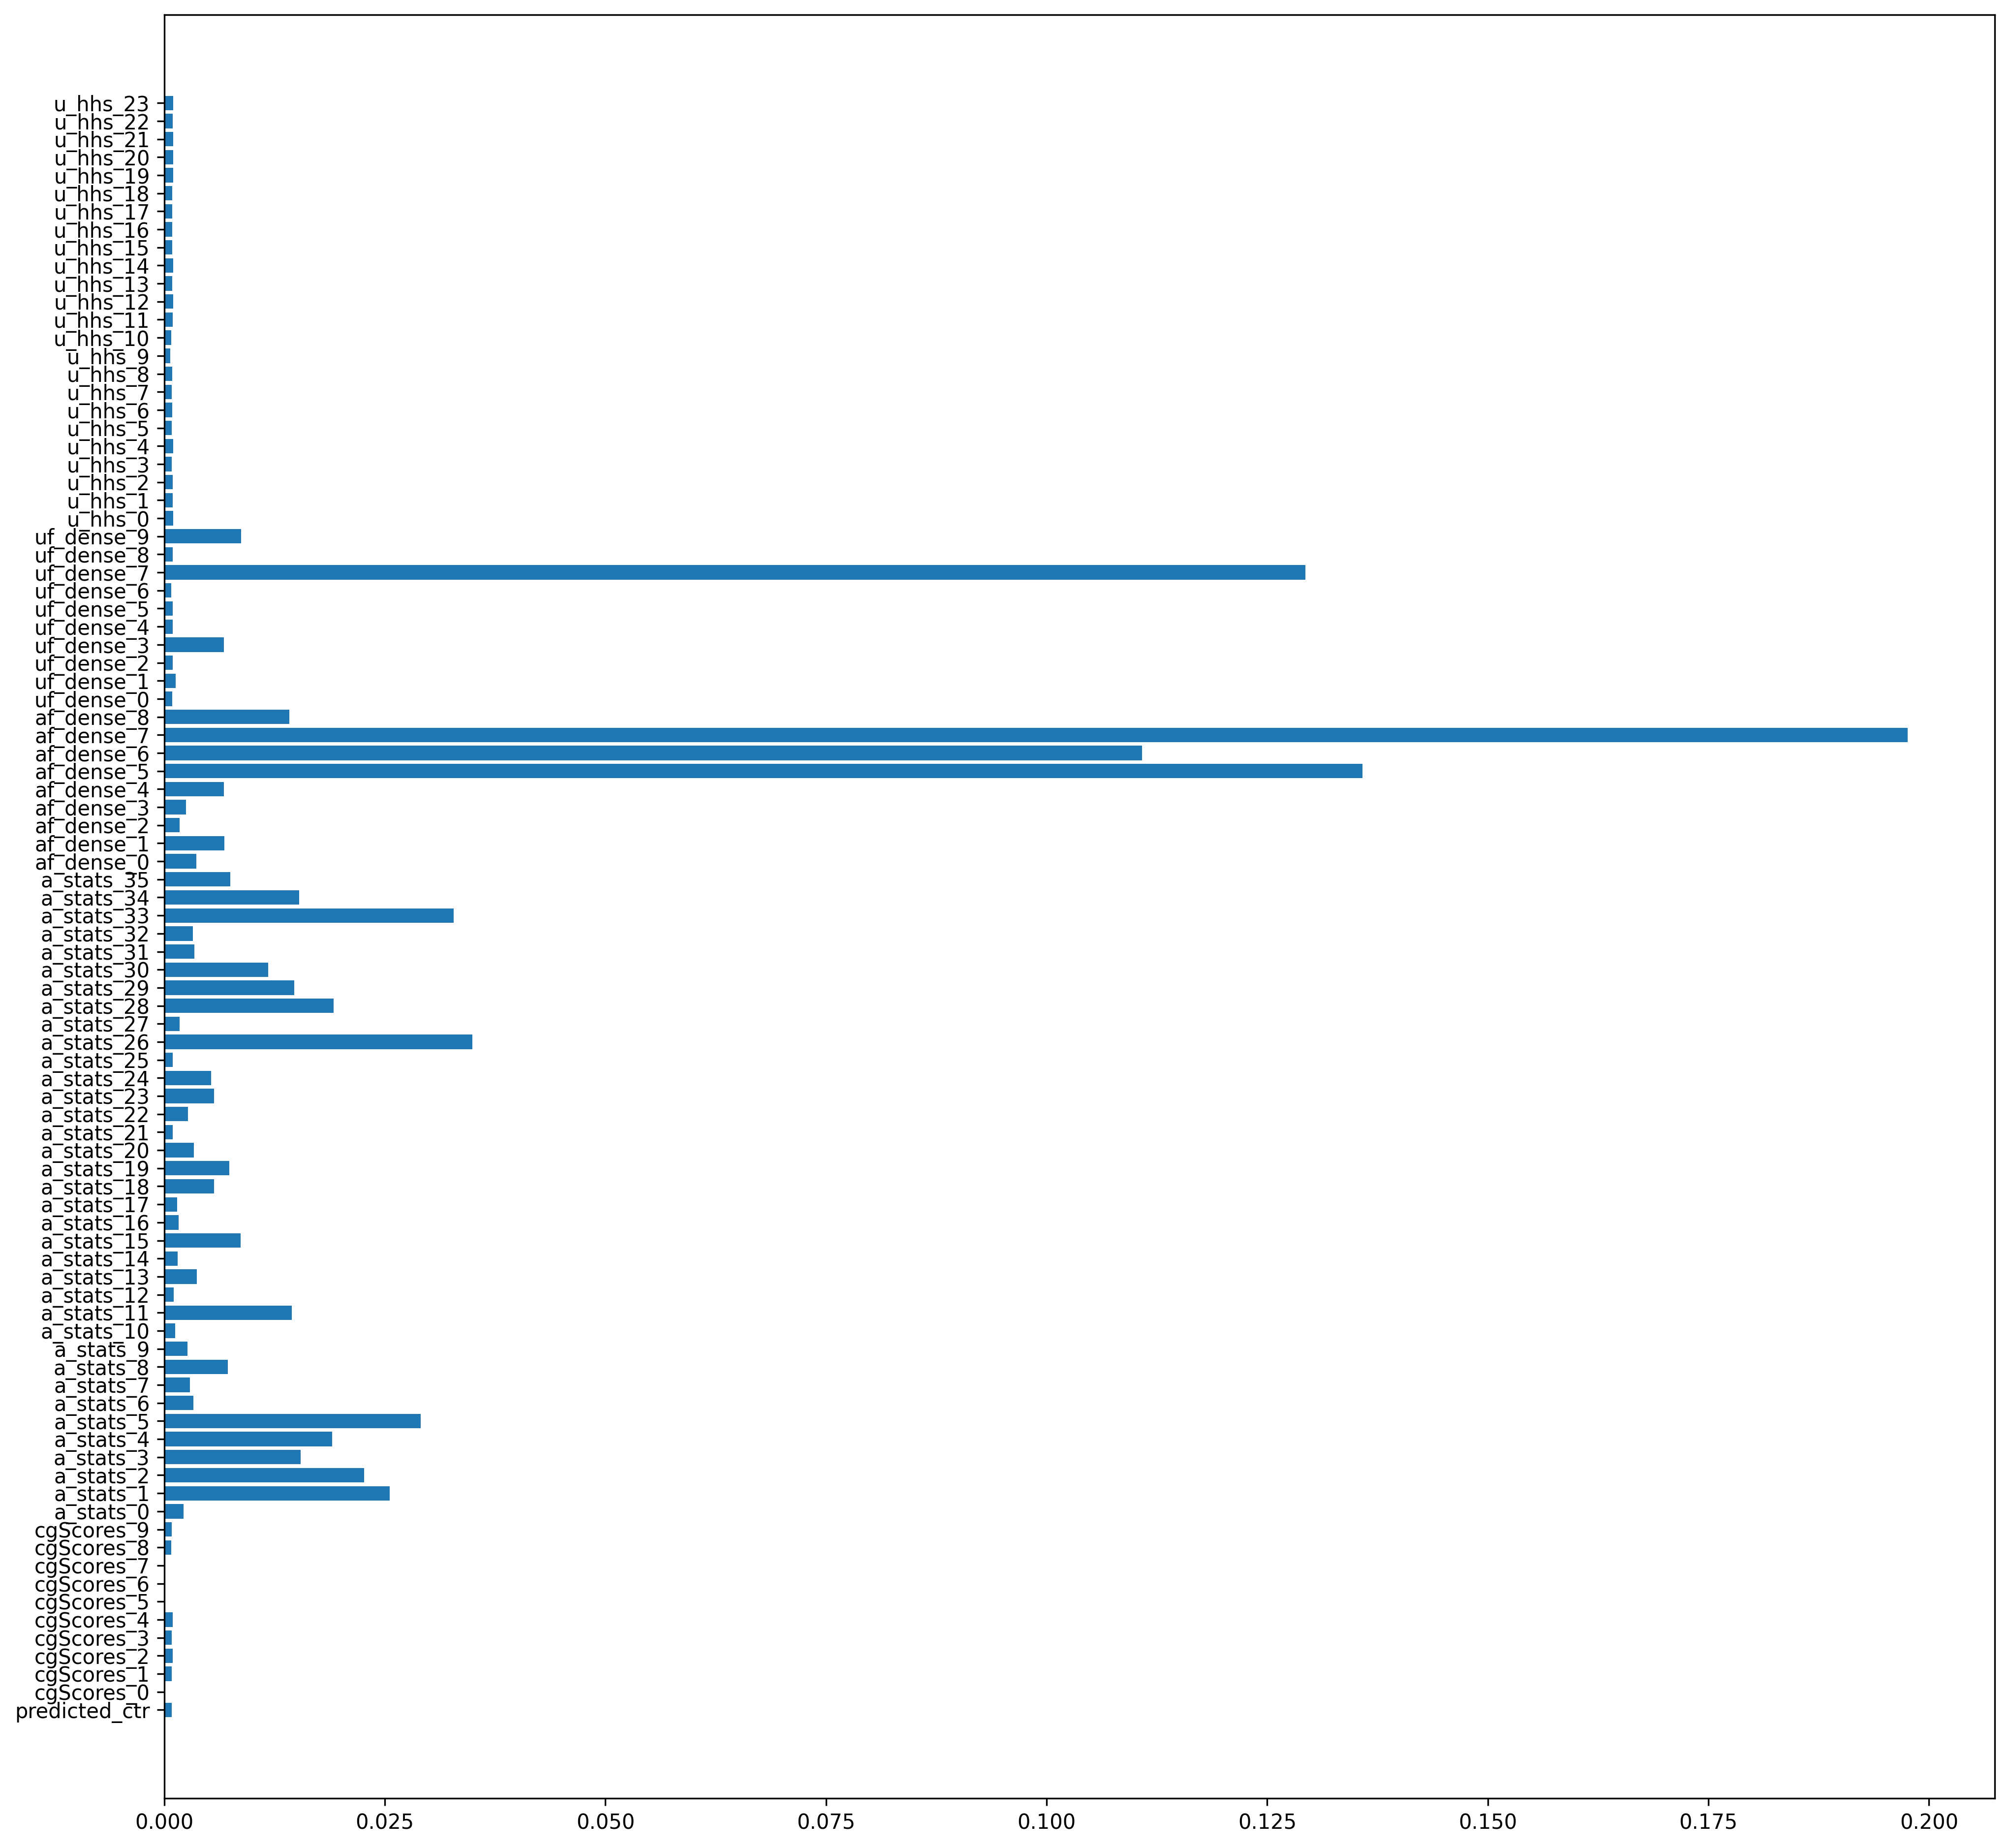

In [22]:
plt.figure(figsize=(16, 16), dpi=300)
plt.barh(feature_columns, gbdt_model.feature_importances_)

## DNN push ranker & For You GBDT ranker

In [4]:
## DNN push-ranker
# dnn_model_name = f'{train_days}-day'
dnn_model_name = f'original--{train_day}'

hps = getattr(pushranker.hyperparam, push_type)
dnn_model_1 = pushranker.model.make_model_assembly(hps, input_module.input_spec)
dnn_model_1.hazard_model.load_weights(f'./model/{push_type}-push/DNN/{dnn_model_name}/pushranker')
pushranker.model.initialize_for_training(dnn_model_1, hps)

NumericFeature(key='predicted_ctr', shape=[], dtype=tf.float32)
CategoricalFeature(key='push_id', shape=[], vocab_size=100, has_weight=False, do_own_hash=True, embedding_key=None, score_key='', key_dtype=tf.string)
CategoricalFeature(key='u_cate', shape=[None], vocab_size=10000, has_weight=True, do_own_hash=False, embedding_key=None, score_key='_w', key_dtype=tf.int64)
CategoricalFeature(key='u_catev2', shape=[None], vocab_size=10000, has_weight=True, do_own_hash=True, embedding_key='catev2', score_key='_w', key_dtype=tf.int64)
CategoricalFeature(key='u_pub', shape=[None], vocab_size=60000, has_weight=True, do_own_hash=True, embedding_key='site_id', score_key='_w', key_dtype=tf.int64)
CategoricalFeature(key='u_pub_ctr', shape=[None], vocab_size=60000, has_weight=True, do_own_hash=True, embedding_key='site_id', score_key='_w', key_dtype=tf.int64)
CategoricalFeature(key='u_kw', shape=[None], vocab_size=200000, has_weight=True, do_own_hash=False, embedding_key=None, score_key='_s', key_dt

Assembly(training_adapter=<pushranker.model.TrainingAdapter object at 0x7f44e0593750>, hazard_model=<tensorflow.python.keras.engine.functional.Functional object at 0x7f450c38fb90>)

In [31]:
%%time
dnn_pred_1 = dnn_model_1.training_adapter.predict(test_ds)

CPU times: user 4h 26min 51s, sys: 4h 23min 45s, total: 8h 50min 36s
Wall time: 28min 30s


In [32]:
dnn_pred_ctr_1 = np.array([s[0] for s in dnn_pred_1])

In [7]:
## DNN push-ranker
# dnn_model_name = f'{train_days}-day'
dnn_model_name = f'6-day--{train_day}'

hps = getattr(pushranker.hyperparam, push_type)
dnn_model_2 = pushranker.model.make_model_assembly(hps, input_module.less_ids_input_spec)
dnn_model_2.hazard_model.load_weights(f'./model/{push_type}-push/DNN/{dnn_model_name}/pushranker')
pushranker.model.initialize_for_training(dnn_model_2, hps)

NumericFeature(key='predicted_ctr', shape=[], dtype=tf.float32)
CategoricalFeature(key='u_cate', shape=[None], vocab_size=10000, has_weight=True, do_own_hash=False, embedding_key=None, score_key='_w', key_dtype=tf.int64)
CategoricalFeature(key='u_catev2', shape=[None], vocab_size=10000, has_weight=True, do_own_hash=True, embedding_key='catev2', score_key='_w', key_dtype=tf.int64)
CategoricalFeature(key='u_pub', shape=[None], vocab_size=60000, has_weight=True, do_own_hash=True, embedding_key='site_id', score_key='_w', key_dtype=tf.int64)
CategoricalFeature(key='u_pub_ctr', shape=[None], vocab_size=60000, has_weight=True, do_own_hash=True, embedding_key='site_id', score_key='_w', key_dtype=tf.int64)
CategoricalFeature(key='u_kw', shape=[None], vocab_size=200000, has_weight=True, do_own_hash=False, embedding_key=None, score_key='_s', key_dtype=tf.int64)
NumericFeature(key='cgScores', shape=[10], dtype=tf.float32)
NumericFeature(key='u_hhs', shape=[24], dtype=tf.float32)
NumericFeature(key

Assembly(training_adapter=<pushranker.model.TrainingAdapter object at 0x7f44e00d8890>, hazard_model=<tensorflow.python.keras.engine.functional.Functional object at 0x7f44c830e990>)

In [33]:
%%time
dnn_pred_2 = dnn_model_2.training_adapter.predict(test_ds)

CPU times: user 4h 14min 27s, sys: 4h 19min 30s, total: 8h 33min 57s
Wall time: 28min 26s


In [34]:
dnn_pred_ctr_2 = np.array([s[0] for s in dnn_pred_2])

In [35]:
devtok = list()
label = list()
fy_gbdt_ctr = list()

for feature_batch, label_batch, devtok_batch in test_ds.as_numpy_iterator():
    for f, l, dtk in zip(feature_batch['predicted_ctr'], label_batch, devtok_batch):
        fy_gbdt_ctr.append(f)
        label.append(l)
        devtok.append(dtk[0])
devtok = np.array(devtok)
label = np.array(label)
fy_gbdt_ctr = np.array(fy_gbdt_ctr)

## Predicted CTR Distribution

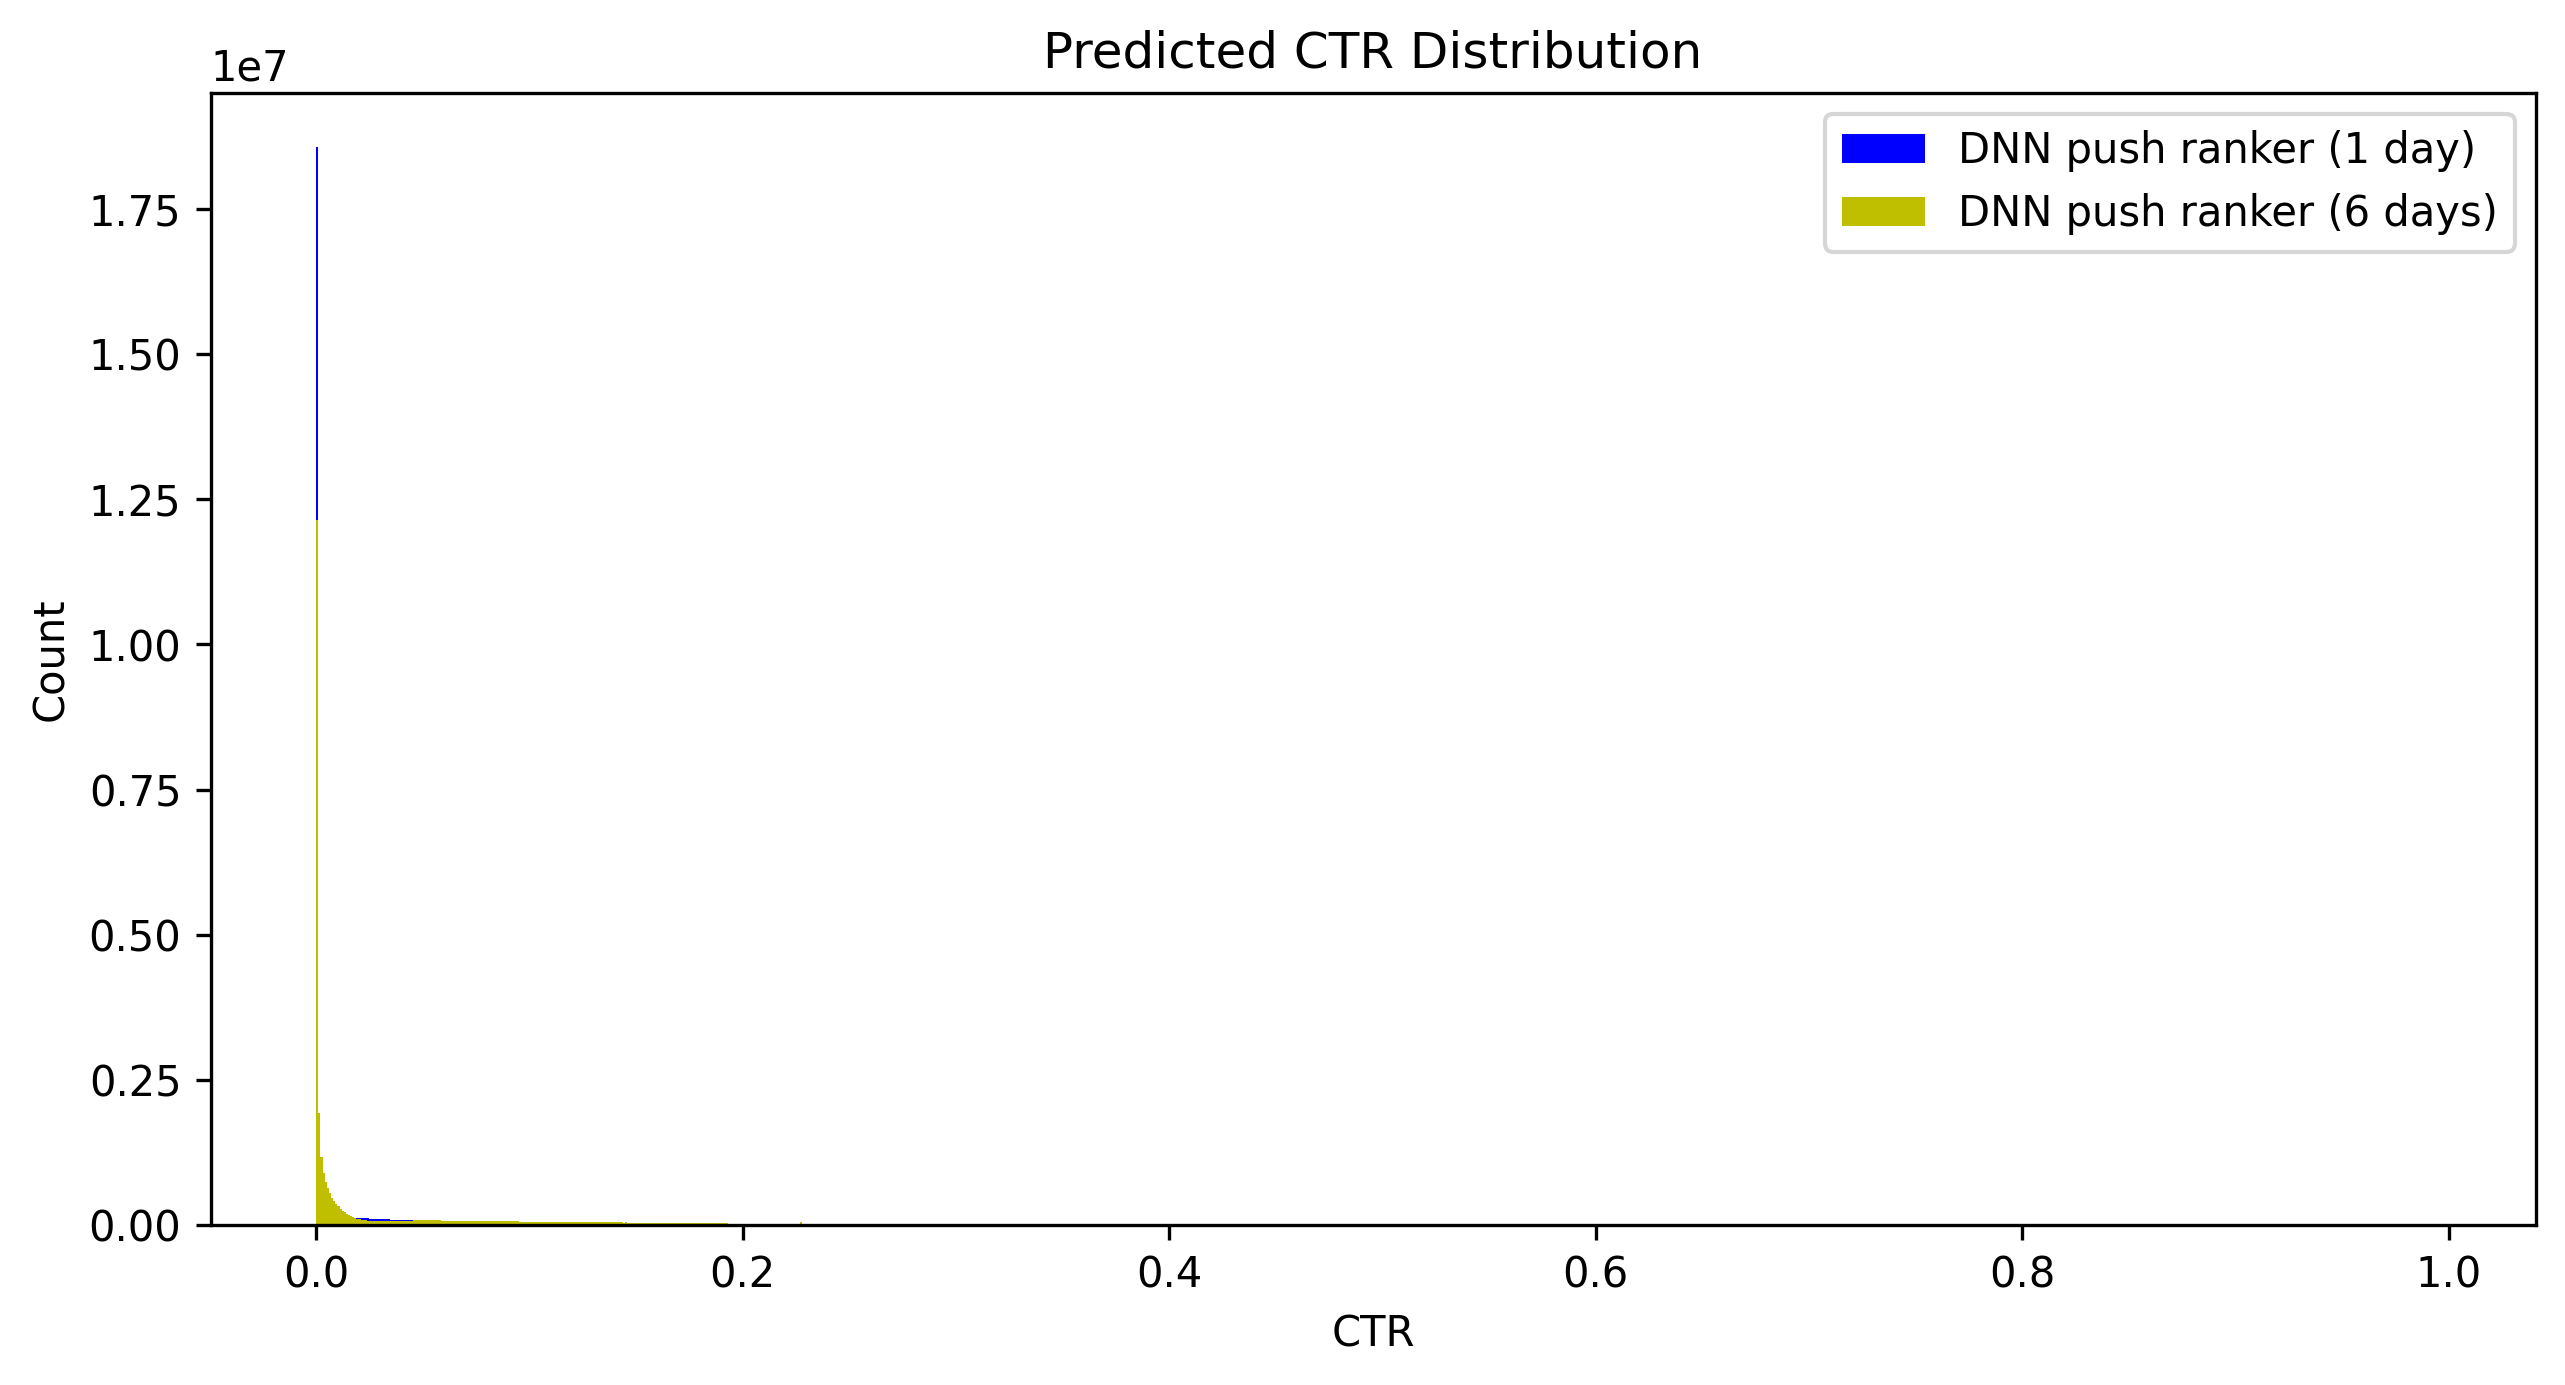

In [11]:
plt.figure(figsize=(10, 5), dpi=300)
# _ = plt.hist(fy_gbdt_ctr, bins=1000, color='r', label='FY GBDT')
# _ = plt.hist(gbdt_pred_ctr, bins=1000, color='g', label='GBDT push ranker')
_ = plt.hist(dnn_pred_ctr_1, bins=1000, color='b', label='DNN push ranker (1 day)')
_ = plt.hist(dnn_pred_ctr_2, bins=1000, color='y', label='DNN push ranker (6 days)')


plt.xlabel('CTR')
plt.ylabel('Count')
plt.title("Predicted CTR Distribution")
plt.legend(loc="upper right")
plt.show()

## ROC AUC

In [40]:
fpr_gbdt, tpr_gbdt, thresholds_gbdt = roc_curve(test_y, gbdt_pred_ctr)
fpr_fy_gbdt, tpr_fy_gbdt, thresholds_fy_gbdt = roc_curve(label, fy_gbdt_ctr)
fpr_dnn1, tpr_dnn1, thresholds_dnn1 = roc_curve(label, dnn_pred_ctr_1)
fpr_dnn2, tpr_dnn2, thresholds_dnn2 = roc_curve(label, dnn_pred_ctr_2)

gbdt_auc = auc(fpr_gbdt, tpr_gbdt)
fy_gbdt_auc = auc(fpr_fy_gbdt, tpr_fy_gbdt)
dnn1_auc = auc(fpr_dnn1, tpr_dnn1)
dnn2_auc = auc(fpr_dnn2, tpr_dnn2)

print('GBDT push ranker AUC: ', gbdt_auc)
print('FY GBDT AUC: ', fy_gbdt_auc)
print('DNN1 push ranker AUC: ', dnn1_auc)
print('DNN2 push ranker AUC: ', dnn2_auc)


GBDT push ranker AUC:  0.5774590495263858
DNN1 push ranker AUC:  0.9254269619973948
DNN2 push ranker AUC:  0.9243027002719313
FY GBDT AUC:  0.6988443573162426


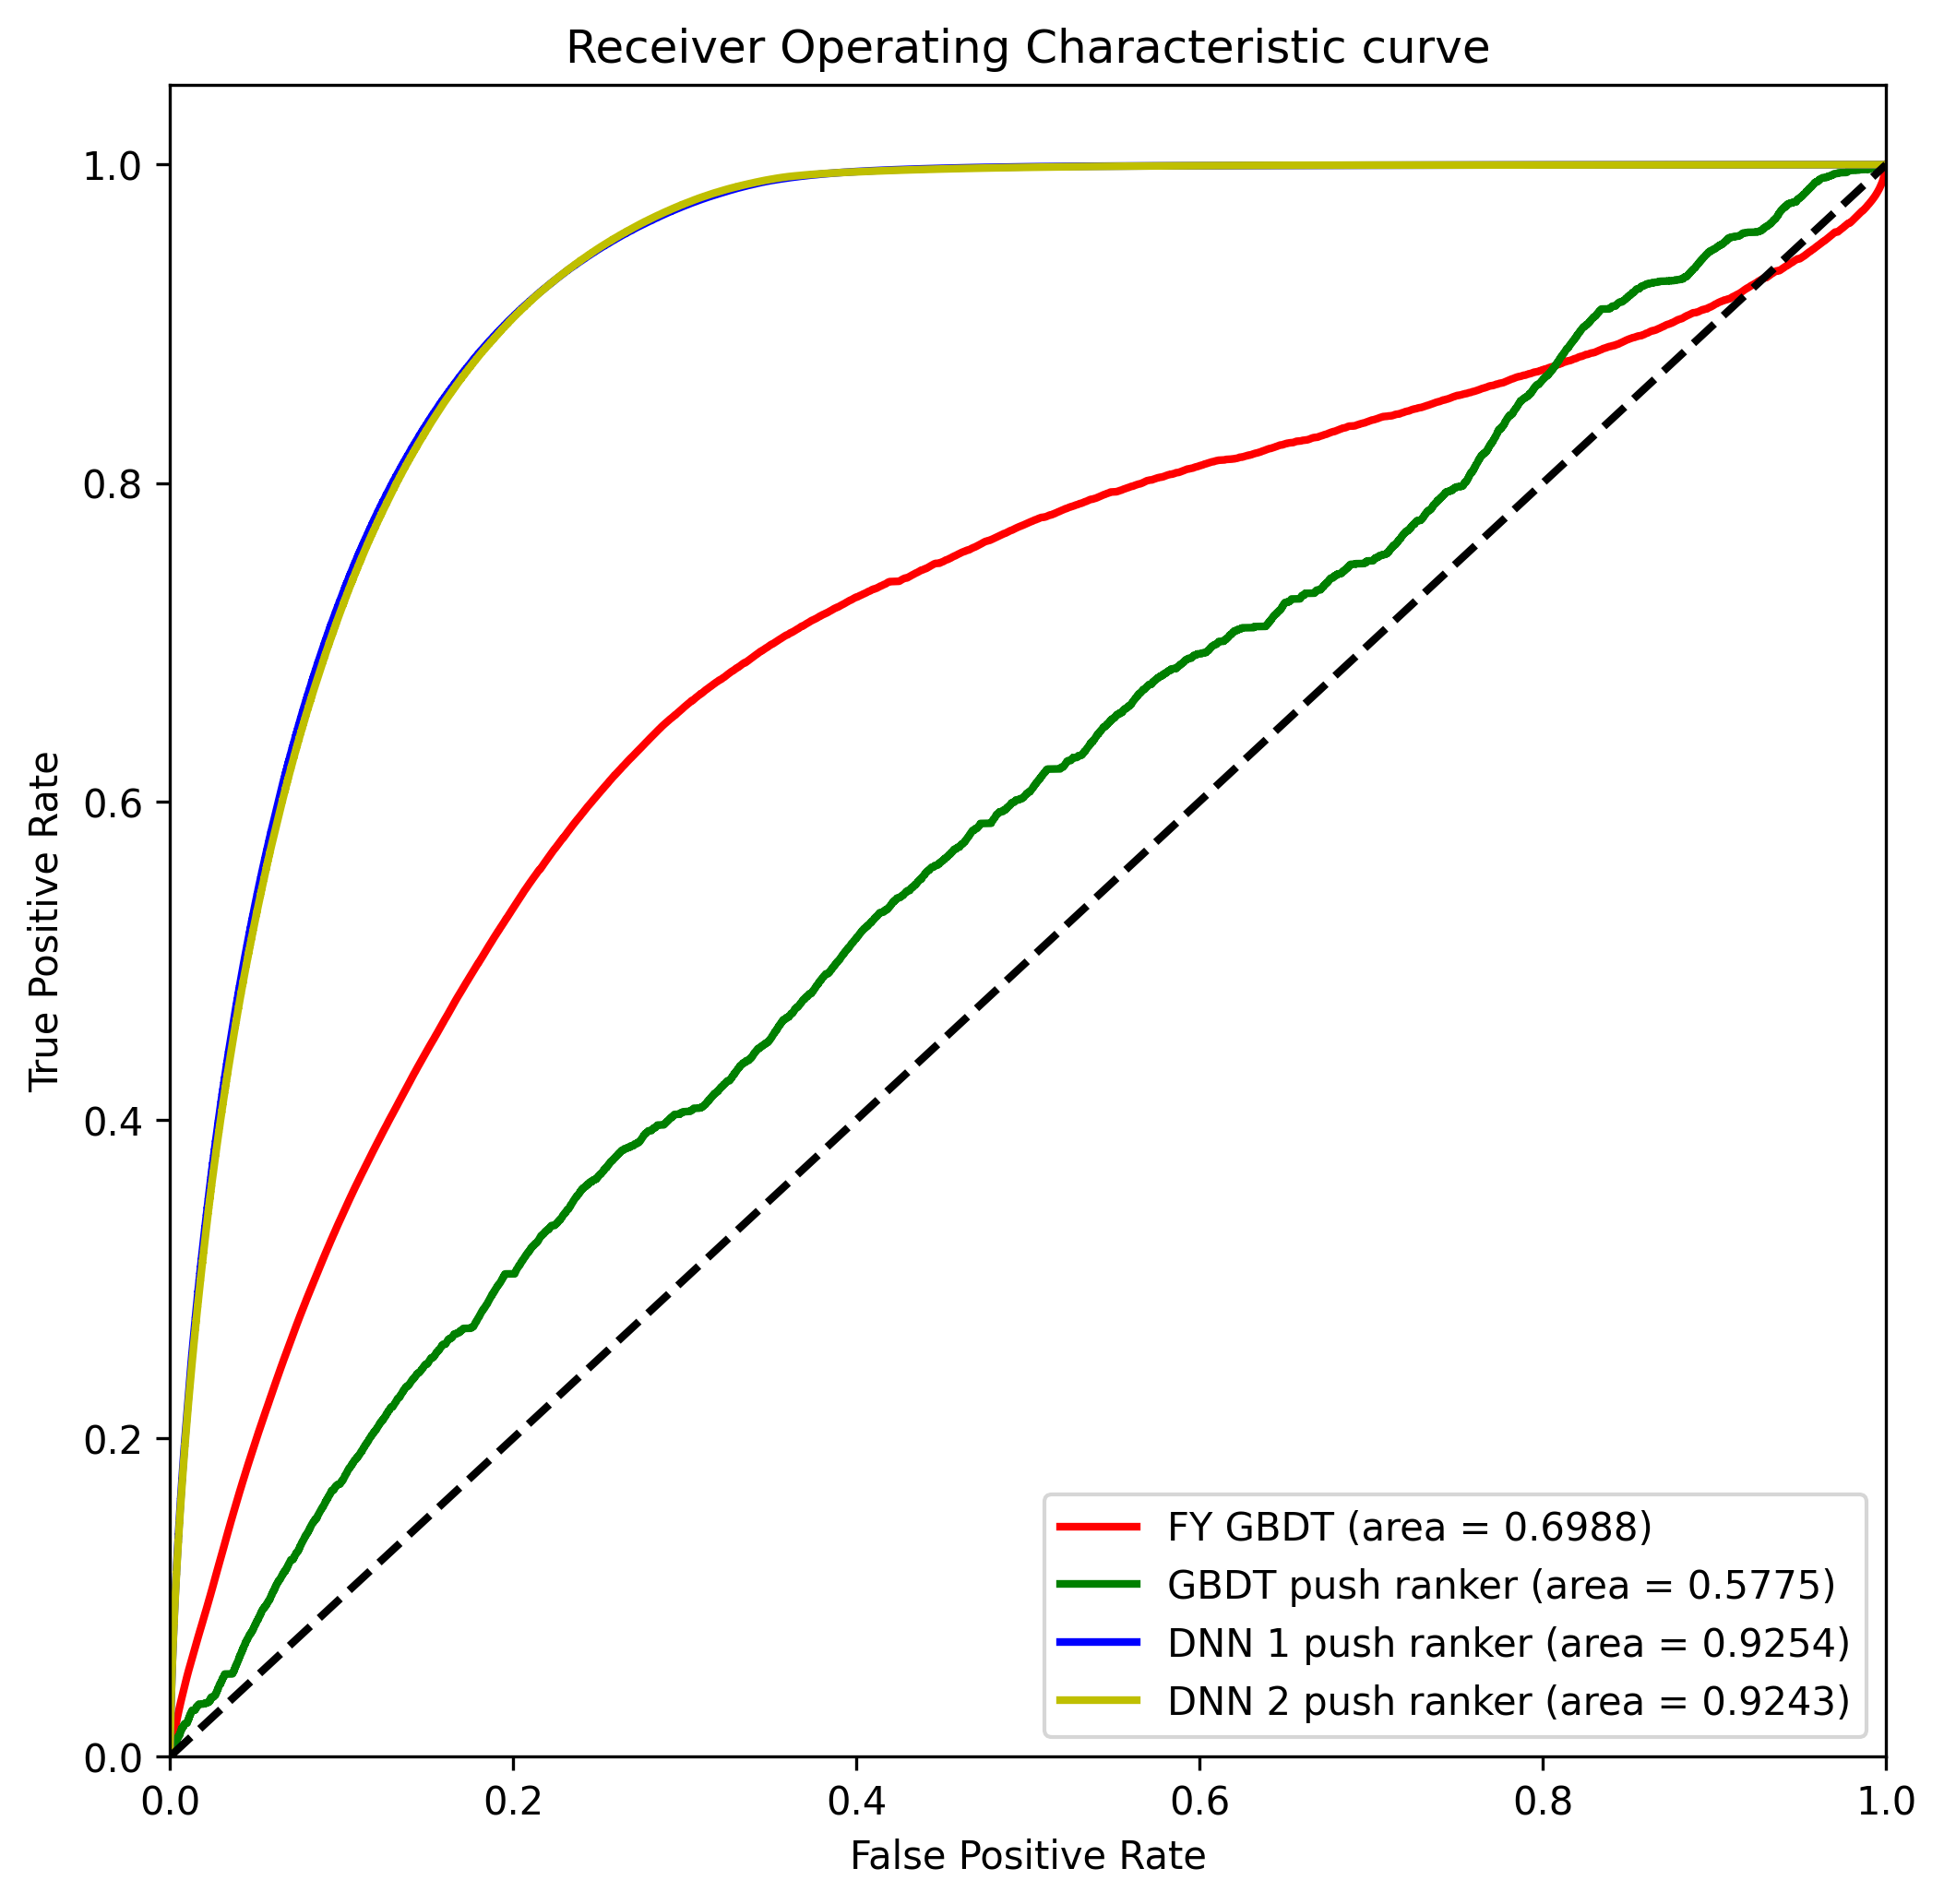

In [55]:
# Plot ROC
plt.figure(figsize=(8, 8), dpi=300)
lw = 2
plt.plot(fpr_fy_gbdt, tpr_fy_gbdt, color='r',
         lw=lw, label='FY GBDT (area = %0.4f)' % fy_gbdt_auc)
plt.plot(fpr_gbdt, tpr_gbdt, color='g',
         lw=lw, label='GBDT push ranker (area = %0.4f)' % gbdt_auc)
plt.plot(fpr_dnn1, tpr_dnn1, color='b',
         lw=lw, label='DNN 1 push ranker (area = %0.4f)' % dnn1_auc)
plt.plot(fpr_dnn2, tpr_dnn2, color='y',
         lw=lw, label='DNN 2 push ranker (area = %0.4f)' % dnn2_auc)
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.show()

## Average Precision

In [47]:
pre_gbdt, rec_gbdt, thresholds_gbdt = precision_recall_curve(test_y, gbdt_pred_ctr)
pre_fy_gbdt, rec_fy_gbdt, thresholds_fy_gbdt = precision_recall_curve(label, fy_gbdt_ctr)
pre_dnn1, rec_dnn1, thresholds_dnn1 = precision_recall_curve(label, dnn_pred_ctr_1)
pre_dnn2, rec_dnn2, thresholds_dnn2 = precision_recall_curve(label, dnn_pred_ctr_2)

gbdt_ap = average_precision_score(test_y, gbdt_pred_ctr)
fy_gbdt_ap = average_precision_score(label, fy_gbdt_ctr)
dnn1_ap = average_precision_score(label, dnn_pred_ctr_1)
dnn2_ap = average_precision_score(label, dnn_pred_ctr_2)

print('GBDT AP: {0:0.4f}'.format(gbdt_ap))
print('FY GBDT AP: {0:0.4f}'.format(fy_gbdt_ap))
print('DNN 1 AP: {0:0.4f}'.format(dnn1_ap))
print('DNN 2 AP: {0:0.4f}'.format(dnn2_ap))

GBDT AP: 0.0925
FY GBDT AP: 0.1671
DNN 1 AP: 0.4743
DNN 2 AP: 0.4680


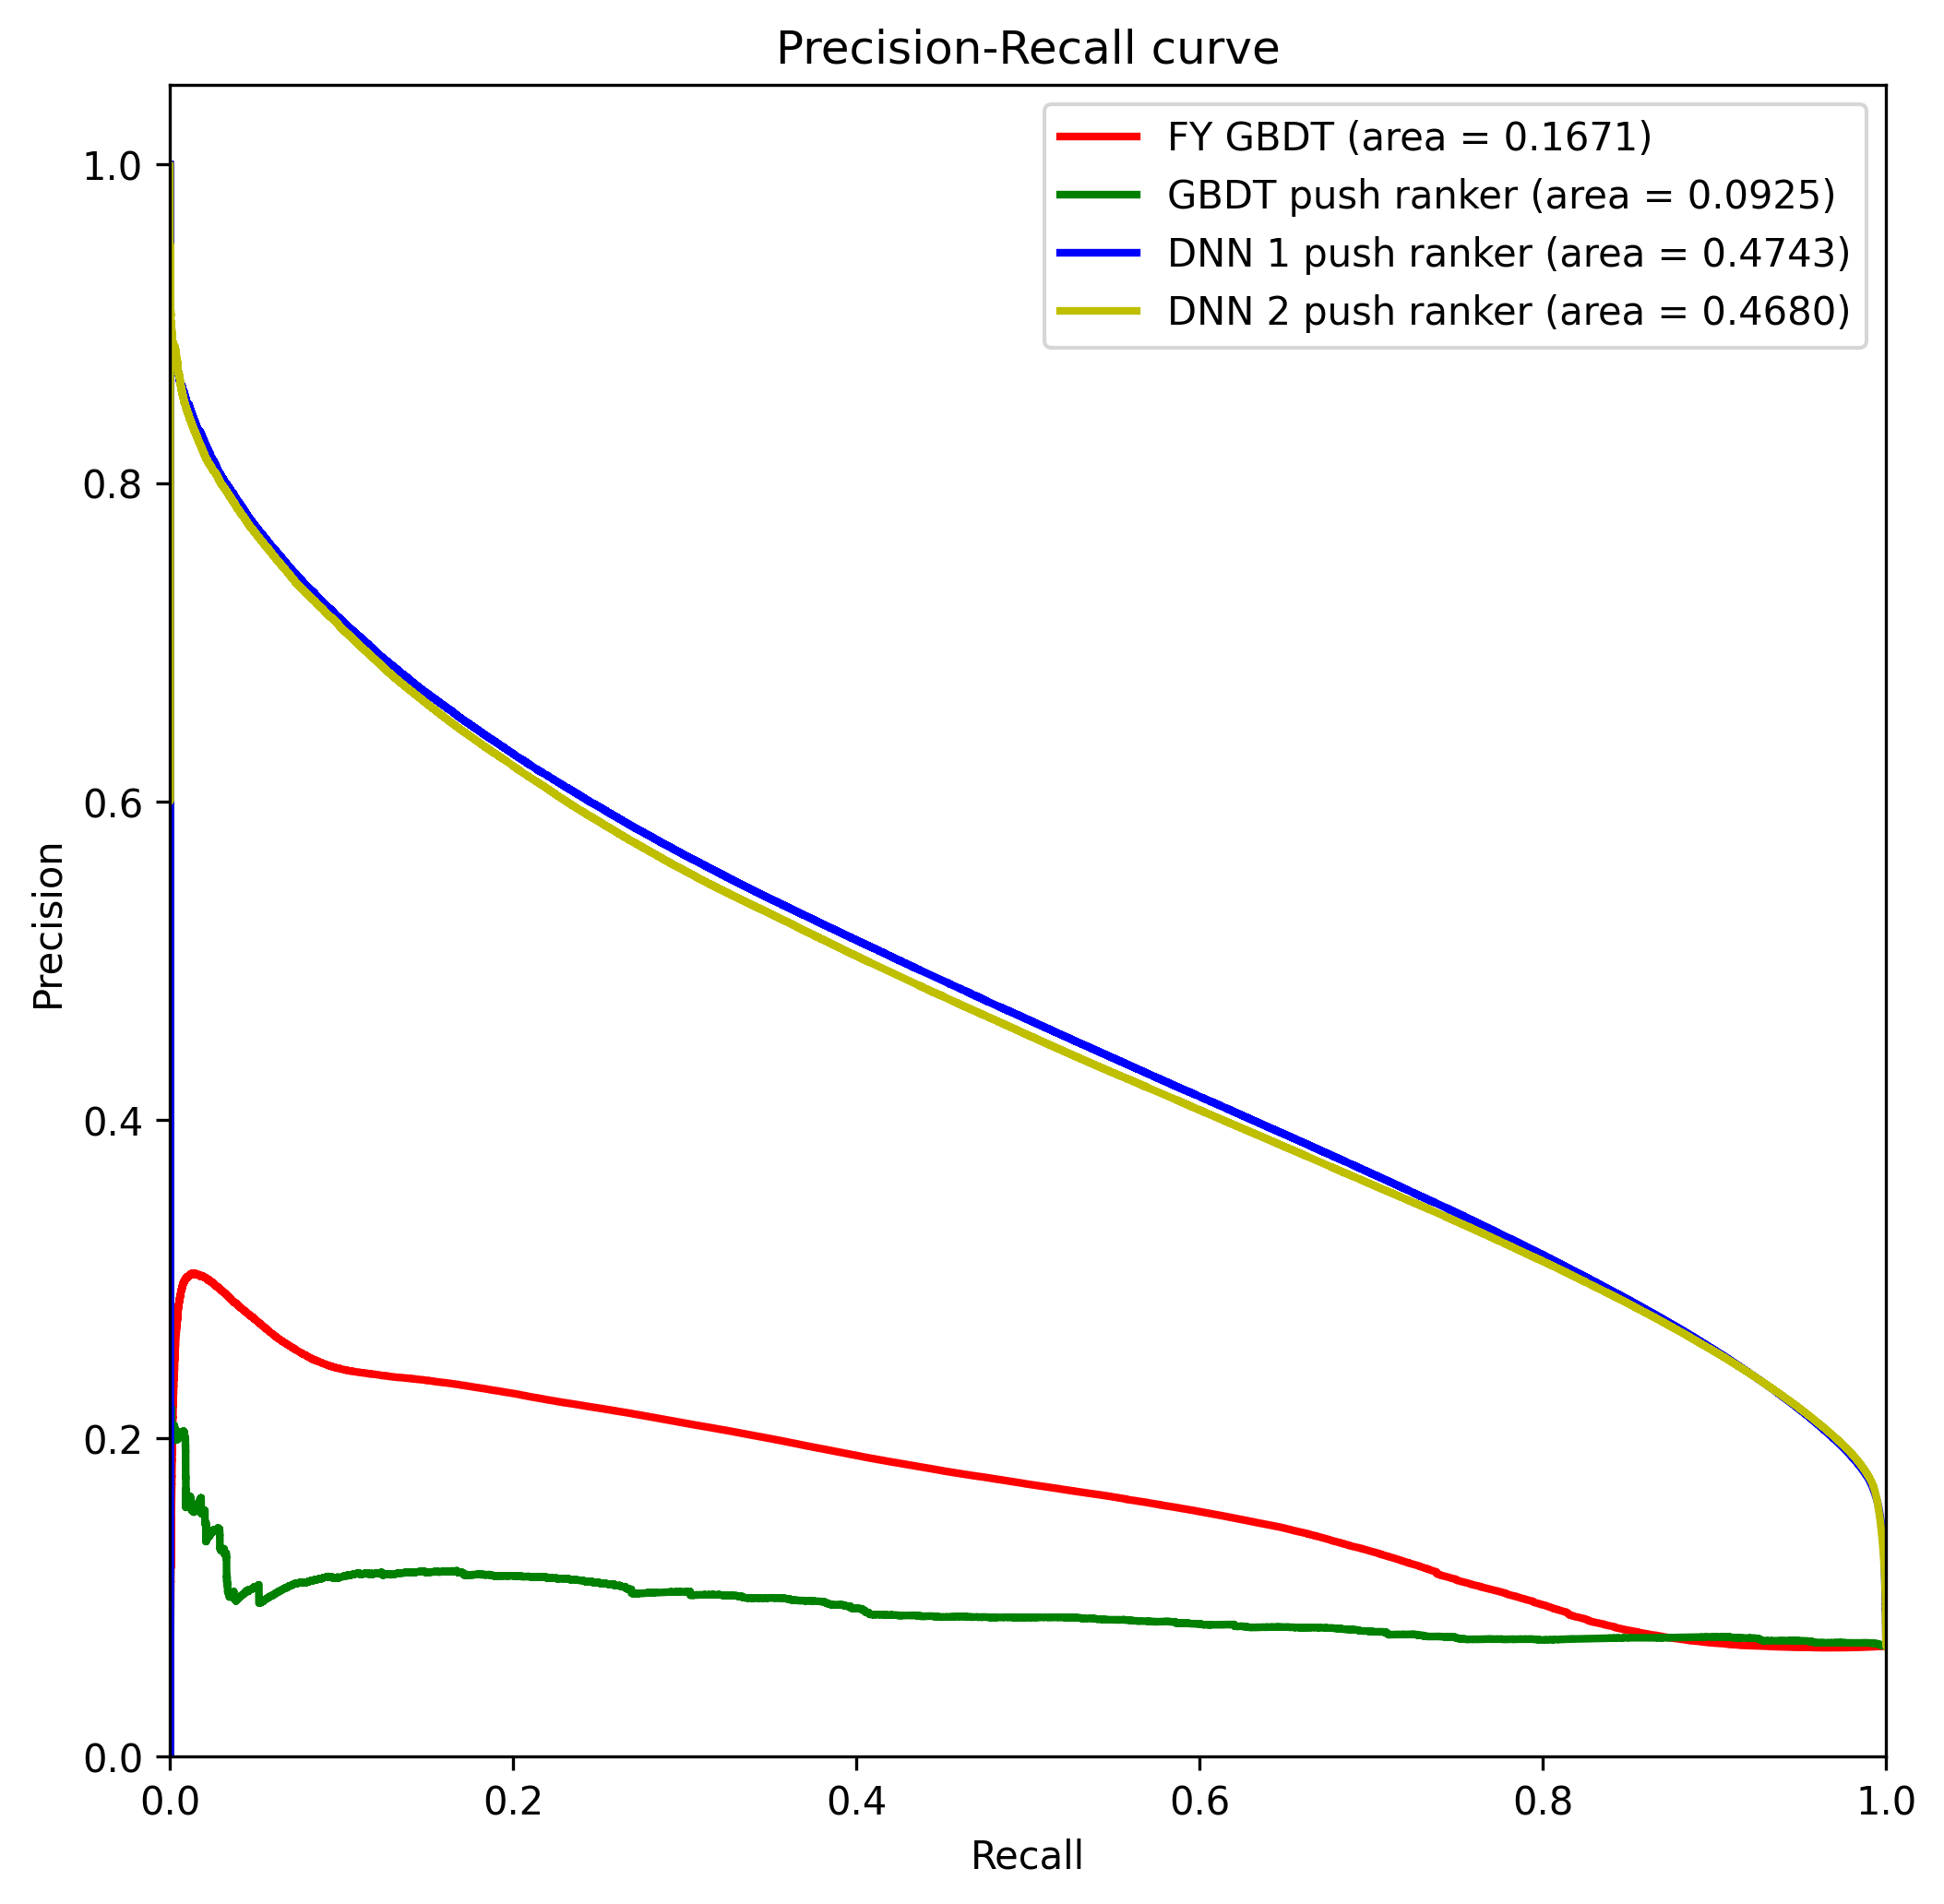

In [54]:
# Plot PR
plt.figure(figsize=(8, 8), dpi=300)
lw = 2
plt.plot(rec_fy_gbdt, pre_fy_gbdt, color='r',
         lw=lw, label='FY GBDT (area = %0.4f)' % fy_gbdt_ap)
plt.plot(rec_gbdt, pre_gbdt, color='g',
         lw=lw, label='GBDT push ranker (area = %0.4f)' % gbdt_ap)
plt.plot(rec_dnn1, pre_dnn1, color='b',
         lw=lw, label='DNN 1 push ranker (area = %0.4f)' % dnn1_ap)
plt.plot(rec_dnn2, pre_dnn2, color='y',
         lw=lw, label='DNN 2 push ranker (area = %0.4f)' % dnn2_ap)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="upper right")
plt.show()

## Overall top-k Precision

In [51]:
gbdt_score_label = list()
fygbdt_score_label = list()
dnn1_score_label = list()
dnn2_score_label = list()
length = len(label)

for i in range(length):
    gbdt_score_label.append((gbdt_pred_ctr[i], label[i]))
    fygbdt_score_label.append((fy_gbdt_ctr[i], label[i]))
    dnn1_score_label.append((dnn_pred_ctr_1[i], label[i]))
    dnn2_score_label.append((dnn_pred_ctr_2[i], label[i]))    

gbdt_score_label.sort(reverse=True)
fygbdt_score_label.sort(reverse=True)
dnn1_score_label.sort(reverse=True)
dnn2_score_label.sort(reverse=True)

In [52]:
topk = [1, 2, 5, 10, 20, 50, 100, 1000, 10000, 100000]

for i in topk:
    print(f'top-{i} precision:')
    print('fy gbdt: {0:0.4f}'.format(sum((l for _, l in fygbdt_score_label[:i]))/i))
    print('gbdt: {0:0.4f}'.format(sum((l for _, l in gbdt_score_label[:i]))/i))    
    print('dnn1: {0:0.4f}'.format(sum((l for _, l in dnn1_score_label[:i]))/i))
    print('dnn2: {0:0.4f}'.format(sum((l for _, l in dnn2_score_label[:i]))/i))    

top-1 precision:
gbdt: 0.0000
fy gbdt: 0.0000
dnn1: 0.0000
dnn2: 1.0000
top-2 precision:
gbdt: 0.5000
fy gbdt: 0.5000
dnn1: 0.5000
dnn2: 1.0000
top-5 precision:
gbdt: 0.2000
fy gbdt: 0.4000
dnn1: 0.6000
dnn2: 0.6000
top-10 precision:
gbdt: 0.1000
fy gbdt: 0.2000
dnn1: 0.7000
dnn2: 0.8000
top-20 precision:
gbdt: 0.1500
fy gbdt: 0.1000
dnn1: 0.8000
dnn2: 0.9000
top-50 precision:
gbdt: 0.1800
fy gbdt: 0.0600
dnn1: 0.7400
dnn2: 0.9400
top-100 precision:
gbdt: 0.2200
fy gbdt: 0.0400
dnn1: 0.7300
dnn2: 0.9400
top-1000 precision:
gbdt: 0.2270
fy gbdt: 0.0100
dnn1: 0.8620
dnn2: 0.9120
top-10000 precision:
gbdt: 0.2155
fy gbdt: 0.0802
dnn1: 0.8740
dnn2: 0.8809
top-100000 precision:
gbdt: 0.2040
fy gbdt: 0.3029
dnn1: 0.8007
dnn2: 0.7964


In [53]:
topk = [10000]

for i in topk:
    print(f'top-{i} precision:')
    print('fy gbdt: {0:0.4f}'.format(sum((l for _, l in fygbdt_score_label[:i]))/i))
    print('gbdt: {0:0.4f}'.format(sum((l for _, l in gbdt_score_label[:i]))/i))
    print('dnn1: {0:0.4f}'.format(sum((l for _, l in dnn1_score_label[:i]))/i))
    print('dnn2: {0:0.4f}'.format(sum((l for _, l in dnn2_score_label[:i]))/i))    

top-10000 precision:
fy gbdt: 0.0802
gbdt: 0.2155
dnn1: 0.8740
dnn2: 0.8809


## gAUC

In [36]:
# len_samples = len(devtok)
# user_fy_gbdt = collections.defaultdict(list)
# user_push_gbdt = collections.defaultdict(list)
# user_dnn1 = collections.defaultdict(list)
# user_dnn2 = collections.defaultdict(list)
# for i in range(len_samples):
#     user_fy_gbdt[devtok[i]].append((fy_gbdt_ctr[i], label[i]))
#     user_push_gbdt[devtok[i]].append((gbdt_pred_ctr[i], label[i]))
#     user_dnn1[devtok[i]].append((dnn_pred_ctr_1[i], label[i]))
#     user_dnn2[devtok[i]].append((dnn_pred_ctr_2[i], label[i]))
# assert len(user_fy_gbdt) == len(user_push_gbdt) == len(user_dnn1) == len(user_dnn2)

In [37]:
%%time
len_samples = len(devtok)
user_fy_gbdt = collections.defaultdict(lambda: collections.defaultdict(list))
# user_push_gbdt = collections.defaultdict(lambda: collections.defaultdict(list))
user_dnn1 = collections.defaultdict(lambda: collections.defaultdict(list))
user_dnn2 = collections.defaultdict(lambda: collections.defaultdict(list))
for i in range(len_samples):
    user_fy_gbdt[devtok[i]]['score'].append(fy_gbdt_ctr[i])
    user_fy_gbdt[devtok[i]]['label'].append(label[i])
#     user_push_gbdt[devtok[i]]['score'].append(gbdt_pred_ctr[i])
#     user_push_gbdt[devtok[i]]['label'].append(label[i])
    user_dnn1[devtok[i]]['score'].append(dnn_pred_ctr_1[i])
    user_dnn1[devtok[i]]['label'].append(label[i])
    user_dnn2[devtok[i]]['score'].append(dnn_pred_ctr_2[i])
    user_dnn2[devtok[i]]['label'].append(label[i])    
# assert len(user_fy_gbdt) == len(user_push_gbdt) == len(user_dnn1) == len(user_dnn2)

CPU times: user 5min 28s, sys: 1.06 s, total: 5min 29s
Wall time: 5min 29s


In [38]:
# number of users
len(user_fy_gbdt)

15236203

In [39]:
%%time

## get to-be-evaluated users
# dicts = [user_fy_gbdt, user_push_gbdt, user_dnn1, user_dnn2]
dicts = [user_fy_gbdt, user_dnn1, user_dnn2]

def getTBEUsers(d) -> Dict:
    rd = deepcopy(d)
    for user, candidates in d.items():
        l = len(candidates['label'])
        s = sum(candidates['label'])
        if s == 0 or s == l:
            rd.pop(user, None)
    return rd

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(getTBEUsers, param) for param in dicts]
user_fy_gbdt = futures[0].result()
# user_push_gbdt = futures[1].result()
user_dnn1 = futures[1].result()
user_dnn2 = futures[2].result()

CPU times: user 31min 45s, sys: 35.9 s, total: 32min 21s
Wall time: 32min 12s


In [40]:
# number of users to be evaluated
print(len(user_fy_gbdt))
# print(len(user_push_gbdt))
print(len(user_dnn1))
print(len(user_dnn2))

715355
715355
715355


In [41]:
user_fy_gbdt == user_dnn1

False

In [42]:
def gAUC(userNews: DefaultDict) -> Tuple[List]:
    gauc = []
    zero = []
    half = []
    one = []
    for d in userNews.values():
        score = d['score']
        label = d['label']
        s = sum(label)
        if s > 0 and s != len(label):
            fpr, tpr, _ = roc_curve(label, score)
            a = auc(fpr, tpr)
            if a == 0:
                zero.append(len(label))
            elif a == 0.5:
                half.append(len(label))
            elif a == 1:
                one.append(len(label))
            gauc.append(a)
    return gauc, zero, half, one
#     return sum(gauc)/len(gauc)

In [43]:
%%time
# models = [user_fy_gbdt, user_push_gbdt, user_dnn1, user_dnn2]
models = [user_fy_gbdt, user_dnn1, user_dnn2]
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(gAUC, param) for param in models]

CPU times: user 20min 43s, sys: 9min 50s, total: 30min 33s
Wall time: 21min 21s


In [44]:
gauc_fy_gbdt, fygbdt_z, fygbdt_h, fygbdt_o = futures[0].result()
# gauc_push_gbdt, pushgbdt_z, pushgbdt_h, pushgbdt_o = futures[1].result()
gauc_dnn1, dnn1_z, dnn1_h, dnn1_o = futures[1].result()
gauc_dnn2, dnn2_z, dnn2_h, dnn2_o = futures[2].result()

In [45]:
print(len(fygbdt_z), len(fygbdt_h), len(fygbdt_o))
# print(len(pushgbdt_z), len(pushgbdt_h), len(pushgbdt_o))
print(len(dnn1_z), len(dnn1_h), len(dnn1_o))
print(len(dnn2_z), len(dnn2_h), len(dnn2_o))

177512 140140 203188
246943 112748 185349
243933 125692 160141


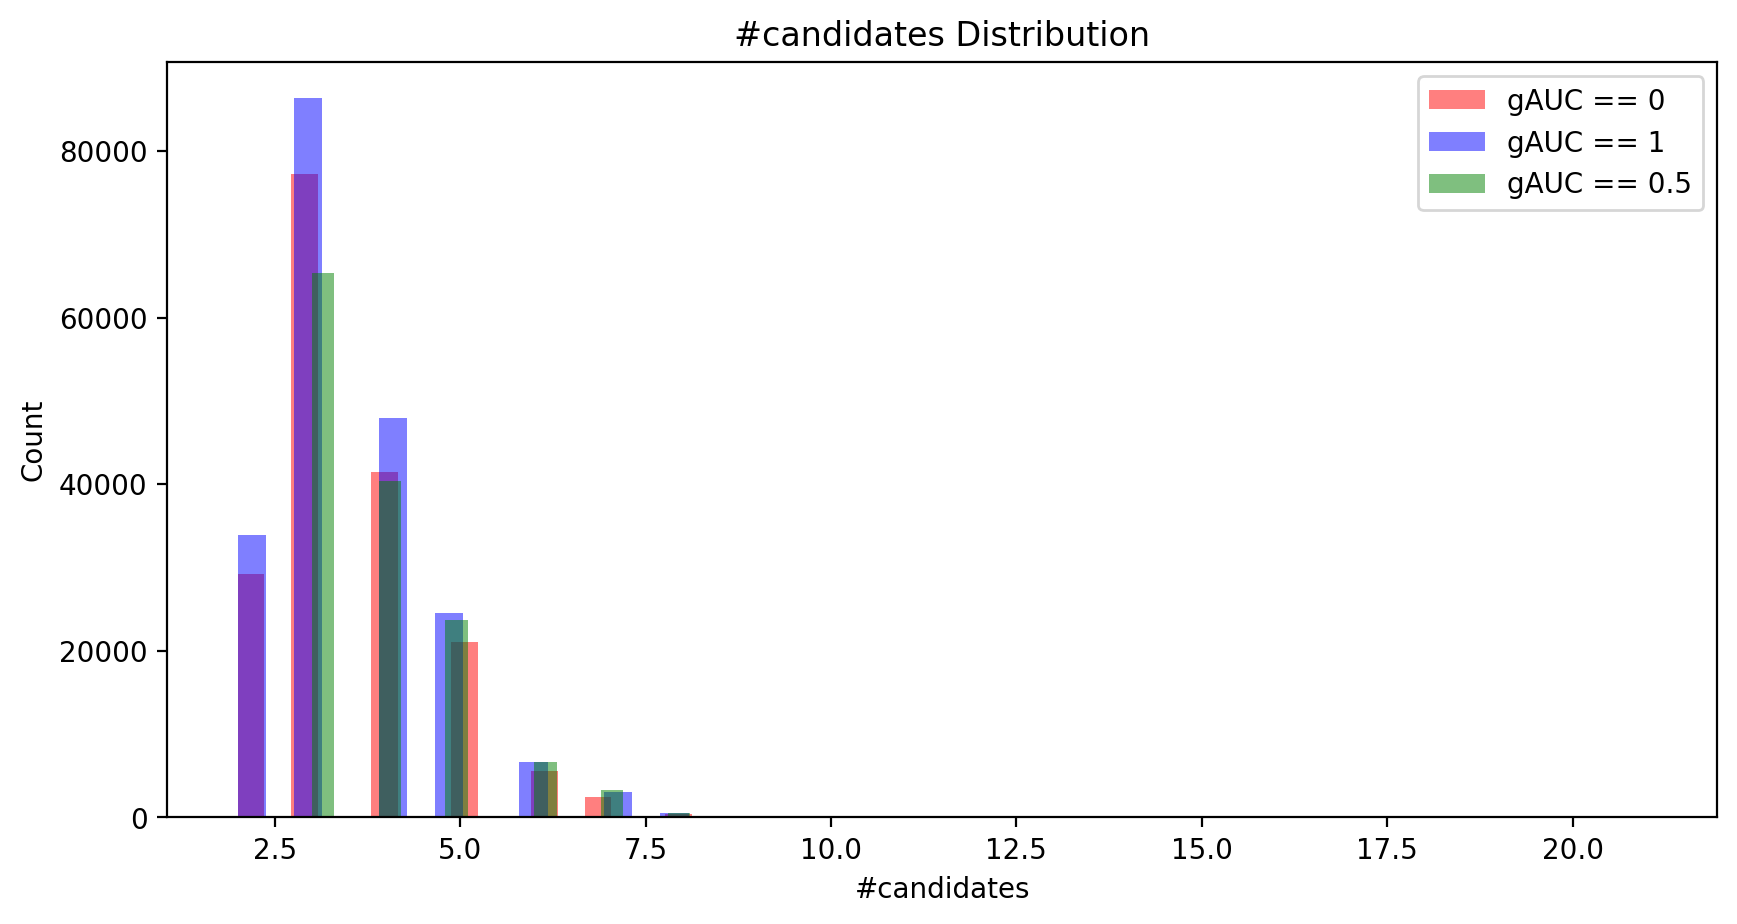

In [46]:
plt.figure(figsize=(10, 5), dpi=200)
_ = plt.hist(fygbdt_z, bins=50, alpha=0.5, color='r', label='gAUC == 0')
_ = plt.hist(fygbdt_o, bins=50, alpha=0.5, color='b', label='gAUC == 1')
_ = plt.hist(fygbdt_h, bins=50, alpha=0.5, color='g', label='gAUC == 0.5')

plt.xlabel('#candidates')
plt.ylabel('Count')
plt.title("#candidates Distribution")
plt.legend(loc="upper right")
plt.show()

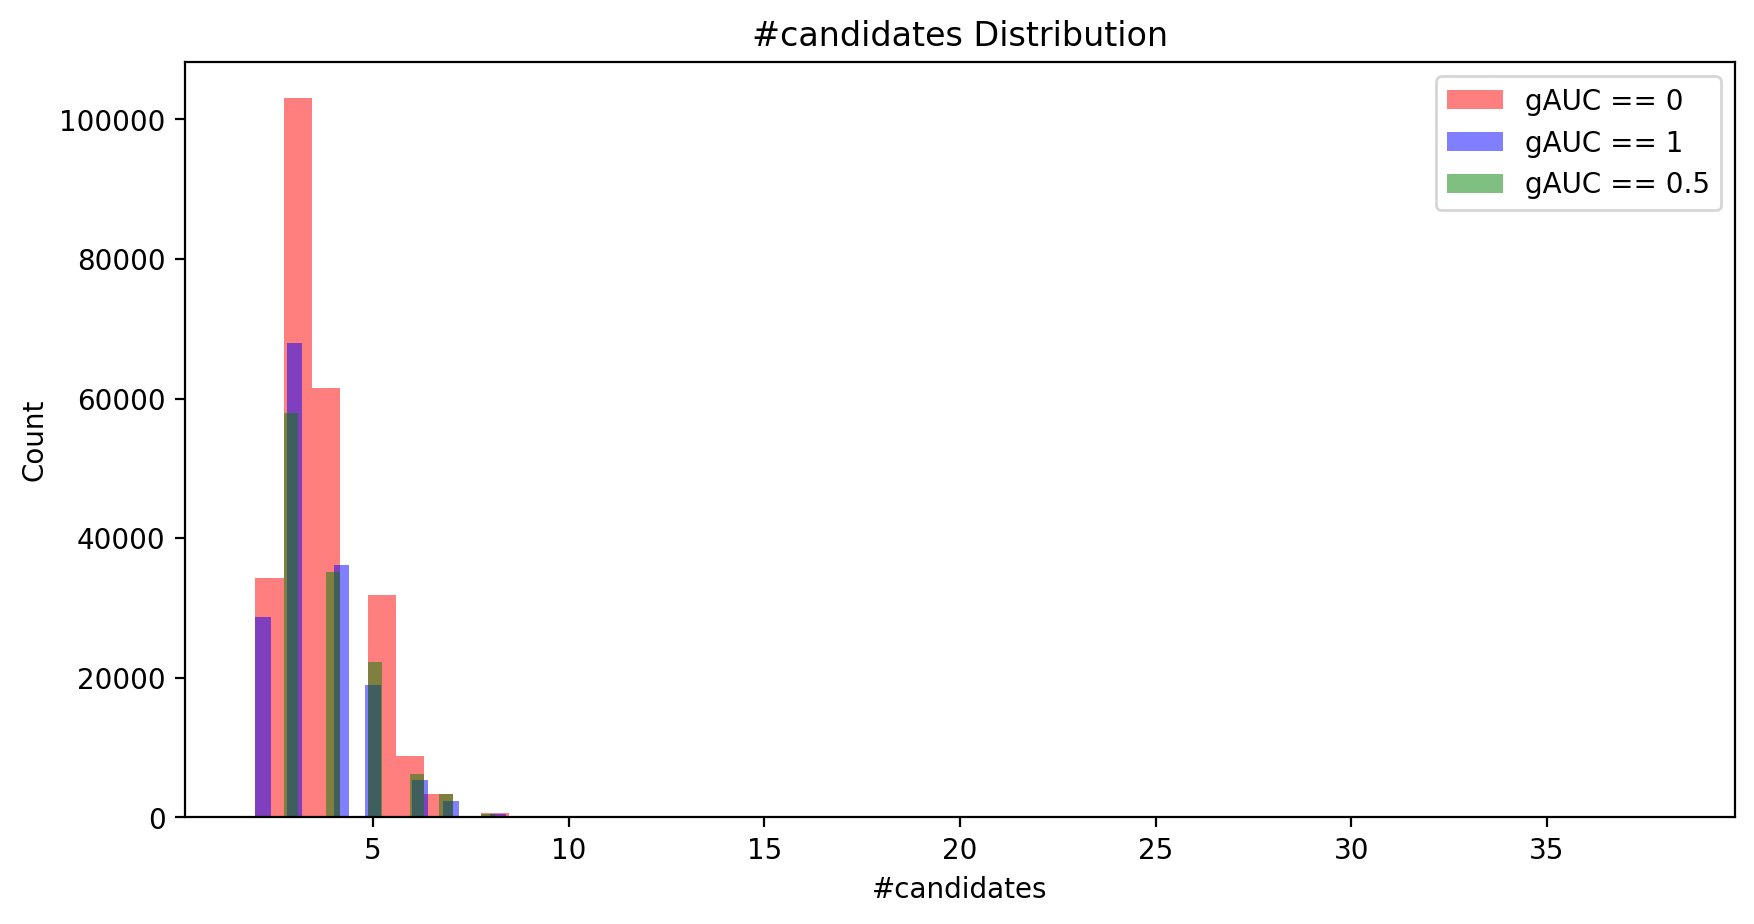

In [47]:
plt.figure(figsize=(10, 5), dpi=200)
_ = plt.hist(dnn2_z, bins=50, alpha=0.5, color='r', label='gAUC == 0')

_ = plt.hist(dnn2_o, bins=50, alpha=0.5, color='b', label='gAUC == 1')
_ = plt.hist(dnn2_h, bins=50, alpha=0.5, color='g', label='gAUC == 0.5')

plt.xlabel('#candidates')
plt.ylabel('Count')
plt.title("#candidates Distribution")
plt.legend(loc="upper right")
plt.show()

In [48]:
# print(len(gauc_fy_gbdt), len(gauc_push_gbdt), len(gauc_dnn1))#, len(gauc_dnn2))
print(len(gauc_fy_gbdt), len(gauc_dnn1), len(gauc_dnn2))

715355 715355 715355


In [49]:
# plt.figure(figsize=(10, 5), dpi=300)
# _ = plt.hist(gauc_fy_gbdt, bins=100, color='r', alpha=0.5, label='fy-gbdt')
# _ = plt.hist(gauc_push_gbdt, bins=100, color='g', alpha=0.5, label='push-gbdt')

# plt.xlabel('gAUC')
# plt.ylabel('Count')
# plt.title("gAUC Distribution")
# plt.legend(loc="best")
# plt.show()

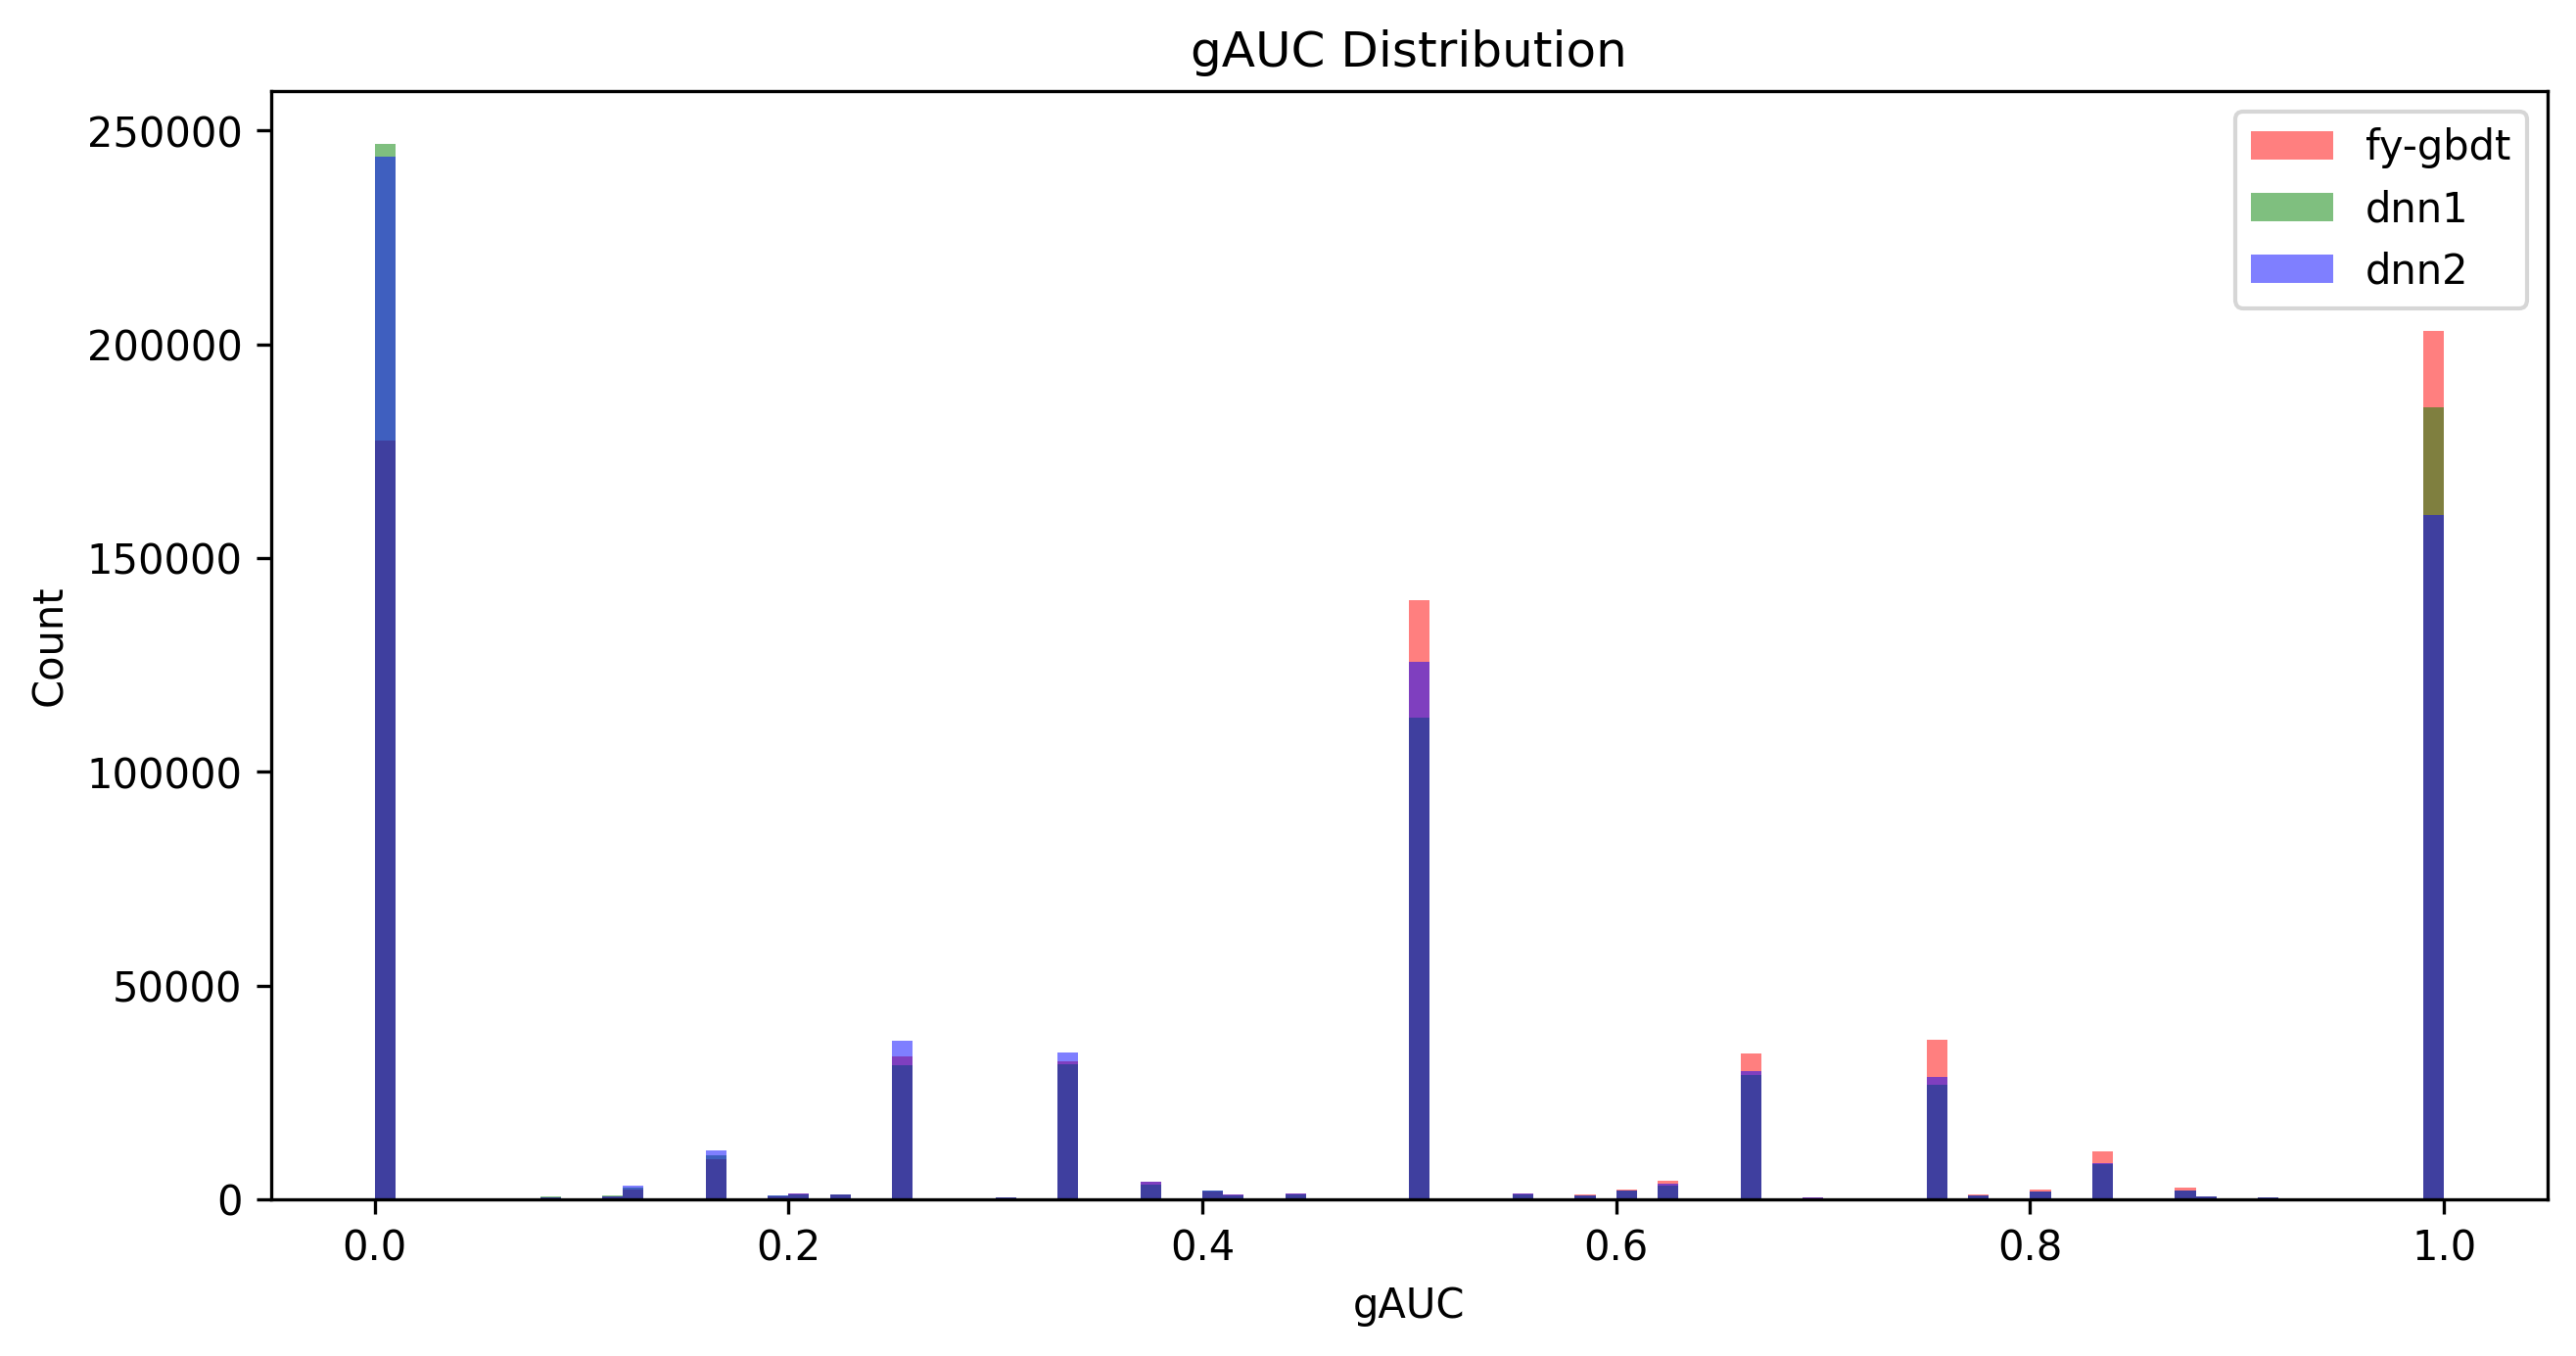

In [50]:
plt.figure(figsize=(10, 5), dpi=300)
_ = plt.hist(gauc_fy_gbdt, bins=100, color='r', alpha=0.5, label='fy-gbdt')
_ = plt.hist(gauc_dnn1, bins=100, color='g', alpha=0.5, label='dnn1')
_ = plt.hist(gauc_dnn2, bins=100, color='b', alpha=0.5, label='dnn2')

plt.xlabel('gAUC')
plt.ylabel('Count')
plt.title("gAUC Distribution")
plt.legend(loc="best")
plt.show()

In [51]:
print(sum(gauc_fy_gbdt)/len(gauc_fy_gbdt))
# print(sum(gauc_push_gbdt)/len(gauc_push_gbdt))
print(sum(gauc_dnn1)/len(gauc_dnn1))
print(sum(gauc_dnn2)/len(gauc_dnn2))

0.5215491830008465
0.4531219220590555
0.43466302161364323


## number of candidates distribution for different gAUC (0, 0.5 1)

In [63]:
%%time

## users filtering out: all candidates are True or all candidates are False
gauc_fy_gbdt = []
gauc_push_gbdt = []
gauc_dnn1 = []
gauc_dnn2 = []

for d in user_fy_gbdt.values():
    score = d['score']
    label = d['label']
    if sum(label) > 0 and sum(label) != len(label):
        fpr, tpr, _ = roc_curve(label, score)
        gauc_fy_gbdt.append(auc(fpr, tpr))
print(sum(gauc_fy_gbdt)/len(gauc_fy_gbdt))
        
for d in user_push_gbdt.values():
    score = d['score']
    label = d['label']
    if sum(label) > 0 and sum(label) != len(label):
        fpr, tpr, _ = roc_curve(label, score)
        gauc_push_gbdt.append(auc(fpr, tpr))
print(sum(gauc_push_gbdt)/len(gauc_push_gbdt))
      
for d in user_dnn1.values():
    score = d['score']
    label = d['label']
    if sum(label) > 0 and sum(label) != len(label):
        fpr, tpr, _ = roc_curve(label, score)
        gauc_dnn1.append(auc(fpr, tpr))
print(sum(gauc_dnn1)/len(gauc_dnn1))
      
for d in user_dnn2.values():
    score = d['score']
    label = d['label']
    if sum(label) > 0 and sum(label) != len(label):
        fpr, tpr, _ = roc_curve(label, score)
        gauc_dnn2.append(auc(fpr, tpr))
print(sum(gauc_dnn2)/len(gauc_dnn2))

0.5221009020555958
0.5221009020555958
0.5221009020555958
0.5221009020555958
CPU times: user 21min 25s, sys: 7.58 ms, total: 21min 25s
Wall time: 21min 25s


In [66]:
%%time
# Concurrent process

def gAUC(userNews: DefaultDict) -> float:
    gauc = []
    for d in userNews.values():
        score = d['score']
        label = d['label']
        s = sum(label)
        if s > 0 and s != len(label):
            fpr, tpr, _ = roc_curve(label, score)
            gauc.append(auc(fpr, tpr))
    return sum(gauc)/len(gauc)
       
models = [user_fy_gbdt, user_push_gbdt, user_dnn1, user_dnn2]
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(gAUC, param) for param in models]
for f in futures:
    print(f.result())

0.5221009020555958
0.5221009020555958
0.5221009020555958
0.5221009020555958
CPU times: user 38min 48s, sys: 13min 59s, total: 52min 47s
Wall time: 36min 1s


In [62]:
# topk = [1, 2, 3]

# def getMeanTopkPrecision(d):
#     for k in topk:
#         p = 0
#         for _, scores_labels in d.items():
#             scores_labels.sort(reverse=True)
#             p += sum(l for _, l in scores_labels[:k])/k
#         p /= len(d)
#         yield p
       
# print(f'fy-gbdt:', list(getMeanTopkPrecision(user_fy_gbdt)))
# print(f'push-gbdt:', list(getMeanTopkPrecision(user_push_gbdt)))
# print(f'dnn:', list(getMeanTopkPrecision(user_dnn)))

In [33]:
# positive sample rate
sum(label)/len(label)

0.0698443305909392

In [34]:
# average number of samples per user
sum(len(article) for article in user_fy_gbdt.values())/len(user_fy_gbdt)

2.2708203205488195

In [35]:
# how many users have more than 1 article
print(f'#total users: {len(user_fy_gbdt)}')
print(f'#users have 1 article: {sum(1 for article in user_fy_gbdt.values() if len(article) == 1)}')
print(f'#users have 1 article and it is pos: {sum(1 for article in user_fy_gbdt.values() if (len(article) == 1) and sum(l for _, l in article)>0)}')
print(f'#users have 2 article: {sum(1 for article in user_fy_gbdt.values() if len(article) == 2)}')
print(f'#users have more than 2 article: {sum(1 for article in user_fy_gbdt.values() if len(article) > 2)}')

#total users: 14850780
#users have 1 article: 4496792
#users have 1 article and it is pos: 46695
#users have 2 article: 4926742
#users have more than 2 article: 5427246


In [3]:
# filter out users 